In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn as sk
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [11]:
data = pd.read_csv('../datasets/WebBouncingData.csv')
data.head(10)

,bounce_time,age,county,location
0,165.548520,16,devon,a
1,167.559314,34,devon,a
2,165.882952,6,devon,a
3,167.685525,19,devon,a
4,169.959681,34,devon,a
5,168.688747,47,devon,a
6,169.619382,7,devon,a
7,164.416273,8,devon,a
8,167.510430,8,devon,a
9,179.606068,7,devon,a


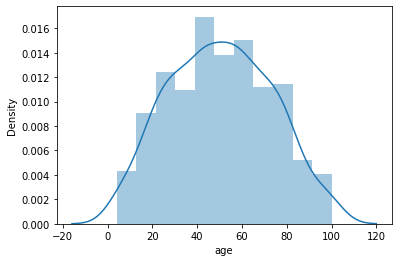

In [12]:
sns.distplot(data.age, kde=True)
plt.show()

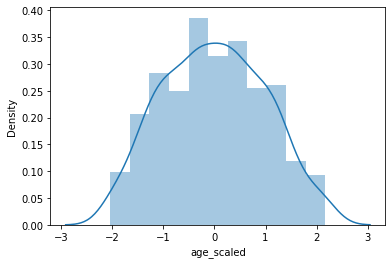

In [13]:
from sklearn import preprocessing

data["age_scaled"] = preprocessing.scale(data.age.values)
sns.distplot(data.age_scaled, kde=True)
plt.show()

In [14]:
counties = data.county.unique()
data_new = pd.concat([data,pd.get_dummies(data.county)],axis=1)
data_new.head()

,bounce_time,age,county,location,age_scaled,cheshire,cumbria,devon,dorset,essex,kent,london,norfolk
0,165.548520,16,devon,a,-1.512654,0,0,1,0,0,0,0,0
1,167.559314,34,devon,a,-0.722871,0,0,1,0,0,0,0,0
2,165.882952,6,devon,a,-1.951423,0,0,1,0,0,0,0,0
3,167.685525,19,devon,a,-1.381024,0,0,1,0,0,0,0,0
4,169.959681,34,devon,a,-0.722871,0,0,1,0,0,0,0,0


# Linear regression considering county as fixed effect
Age and county = Fixed effect

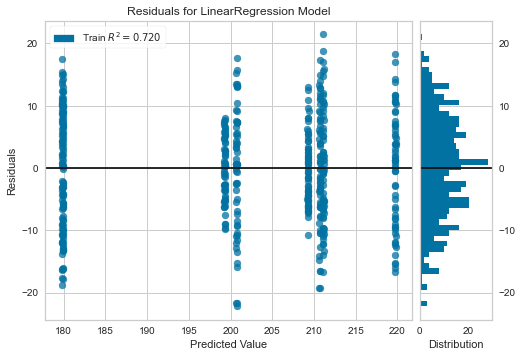

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [16]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import preprocessing
import yellowbrick
from yellowbrick.regressor import ResidualsPlot

# construct our linear regression model
model = LinearRegression(fit_intercept=True)
X = data_new.loc[:,np.concatenate((["age_scaled"],counties))]
y = data_new.bounce_time
model.fit(X, y)

visualizer = ResidualsPlot(estimator=model)
visualizer.fit(X, y)  # Fit the training data to the model
visualizer.poof()

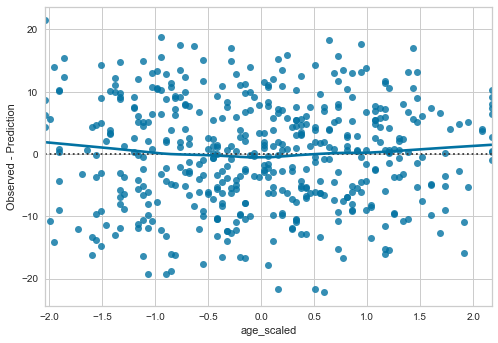

In [17]:
performance = pd.DataFrame()
performance["residuals"] = model.predict(X) - data.bounce_time
performance["age_scaled"] = data_new.age_scaled
performance["predicted"] = model.predict(X)

ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

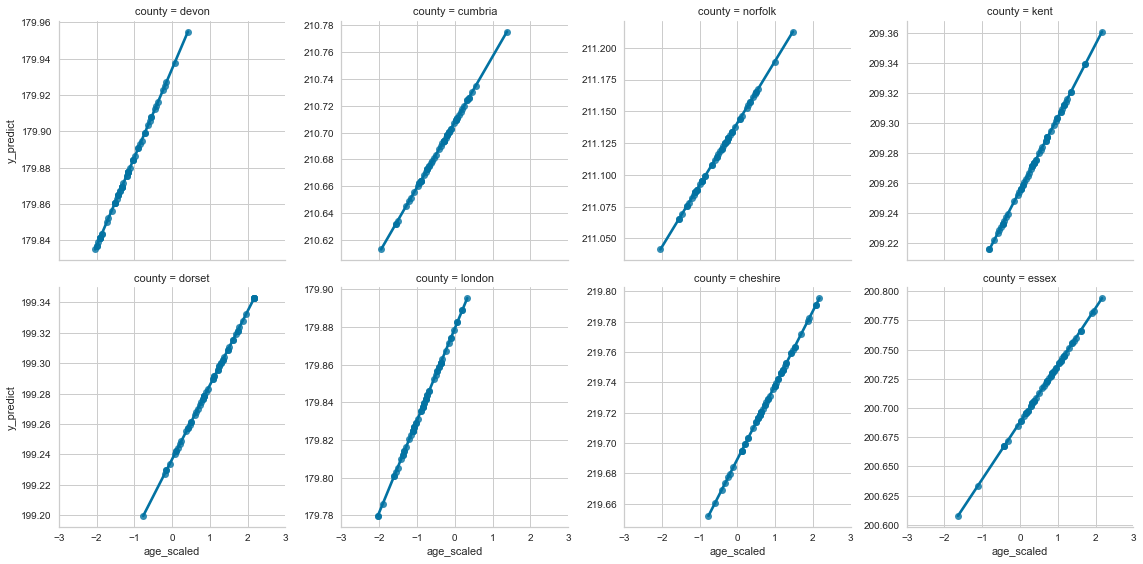

In [18]:
data_new["y_predict"] = model.predict(X)
grid = sns.lmplot(x = "age_scaled", y = "y_predict", col = "county", sharey=False, col_wrap = 4, data = data_new, height=4)
grid.set(xlim=(-3,3))

In [37]:
y_predict = model.predict(X)
RMSE = sqrt(((y-y_predict)**2).values.mean())
print("RMSE: ", RMSE)

RMSE:  8.5633961942025


# Now using MEM

Age = fixed effect\
County and Location = Random effect

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data["location_county"] = data["location"] + "_" + data["county"]

md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["location_county"], re_formula= "~age_scaled")
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    bounce_time
No. Observations:      480        Method:                REML       
No. Groups:            24         Scale:                 23.7942    
Min. group size:       20         Log-Likelihood:        -1504.9078 
Max. group size:       20         Converged:             No         
Mean group size:       20.0                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              201.491    3.448 58.441 0.000 194.734 208.249
age_scaled               0.151    0.393  0.385 0.700  -0.618   0.920
Group Var              282.769   21.275                             
Group x age_scaled Cov  -8.285    2.478                             
age_scaled Var           0.386    0.494           

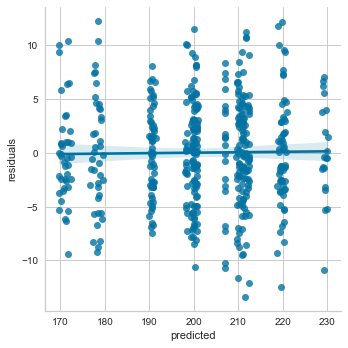

In [22]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

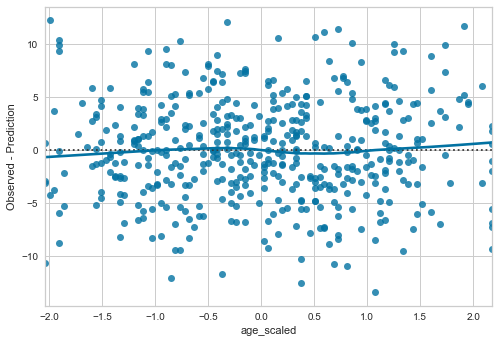

In [23]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [24]:
y_predict = mdf.fittedvalues
y = data.bounce_time
RMSE = sqrt(((y-y_predict)**2).values.mean())
print("RMSE: ", RMSE)

RMSE:  4.764192330647892


## MEM results in reduced RMSE